## Introduction

In this assignment you will implement a Bag Of Visual Words classifier for the Caltech101 dataset, using Histogram of Oriented Gradients as keypoint descriptor.

As seen in the lectures, the approach consists of the following steps:
1. Building a dictionary of visual words:
  - Find all the corners of the training dataset.
  - Extract image patches centred at the found keypoints.
  - Compute the HOG descriptor of each patch.
  - Traing a K-means clustering on all the features.
2. Building the BOVW datasets. Since each image will be represented as a histogram of visual words, for each image in the dataset you will have to:
  - Find the corners, extract image patches, compute their HOG descriptors.
  - Apply the trained k-means on the features to predict their corresponding centroids.
  - Summarize the image as a histogram of the predicted centroids.
3. Training the histogram classifier.

## Part 1. Implementation of corner detection and description.

### Harris corner detection
The Harris response image $R$ of an image is given by:

$$
R = det(M) - k \ trace(M)^2
$$

where $k$ is a pre-determined constant (a typical value is k=0.04) and $M$ is the so called "structure tensor", given by:

$$
M =
\begin{bmatrix}
    w \star (I_x^2) & w \star (I_x I_y) \\
     w \star (I_x I_y) &  w \star (I_y^2)
\end{bmatrix}
$$

where $I_x$ and $I_y$ are the spatial partial derivatives of the image (for example, computed with a Sobel filter) and $w$ is a convolution kernel used as weighting window (for example, a Gaussian blur with a 5x5 kernel).

Since $M$ is 2x2, the determinant and trace can be easily calculated:

$$
\begin{align*}
det(M) &= M_{00} M_{11} - M_{01} M_{10} \\
trace(M) &= M_{00} + M_{11}
\end{align*}
$$


Large values of the response at a given pixel correspond to large values in the eigenvalues of the covariance matrix of the image gradients in the neighborhood of the given pixel. Meaning, large values in the response at a given pixel identify that pixel as a corner.

**1 Implement a function that computes the Harris response of an image:**
  - Compute the Sobel derivatives $I_x$ and $I_y$
  - Compute $I^2_x , I^2_y, I_x I_y$. Note that these are elementwise multiplications, not matrix multiplications.
  - Apply Gaussian blur to $I^2_x , I^2_y, I_x I_y$
  - Compute and return $R$. Use the given determinant and trace formulas. Again, note that the products in the determinant formula are elementwise products and not matrix products.

**2 Implement a corner detection function based on the Harris response.** The function should:
  - Identify a corner if the response at the pixel is bigger than some threshold.
  - Implement Non-Maximum-Supression, since a single keypoint may be detected by many neighboring pixels. If there are keypoints separated by a distance smaller than `d`,only the pixel with the strongest response should remain.
  - Return the coordinates of the detected keypoints.

Show the result of your corner detector applied on some image and identifying the detected keypoints.

**You can only use numpy and opencv for the implementations**

In [1]:
import cv2 as opencv
import numpy as np

def compute_harris_response(img, k=0.04):
  grad_x = opencv.Sobel(img, opencv.CV_64F, 1, 0)
  grad_y = opencv.Sobel(img, opencv.CV_64F, 0, 1)

  ix_squared = np.multiply(grad_x, grad_x)
  ix_iy = np.multiply(grad_x, grad_y)
  iy_squared = np.multiply(grad_y, grad_y)
  
  ix_squared_blurred = opencv.GaussianBlur(ix_squared,(5,5), opencv.CV_64F)
  ix_iy_blurred = opencv.GaussianBlur(ix_iy,(5,5), opencv.CV_64F)
  iy_squared_blurred = opencv.GaussianBlur(iy_squared,(5,5), opencv.CV_64F)
  
  determinant = np.multiply(ix_squared_blurred, iy_squared_blurred) - np.multiply(ix_iy_blurred, ix_iy_blurred)
  trace = np.add(ix_squared_blurred, iy_squared_blurred)
  return determinant -k*trace
  
def find_keypoints(img, response_threshold, d=10):
    corners = np.zeros(img.shape)
    for rowIdx, row in enumerate(img):
        for pixelIdx, pixel in enumerate(row):
            if np.sum(corners[(rowIdx-d//2):(rowIdx+d//2),(pixelIdx-d//2):(pixelIdx+d//2)]) == 0 and (pixel > response_threshold):
                corners[rowIdx][pixelIdx] = 255
    return corners

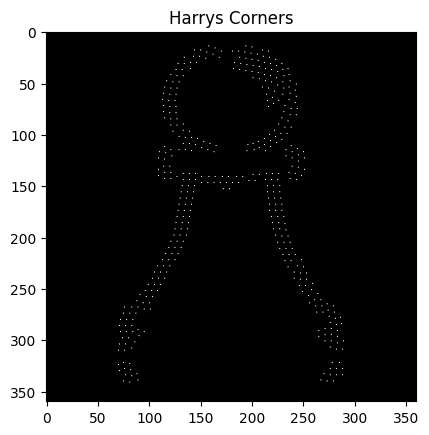

In [2]:
import matplotlib.pyplot as plt

image = opencv.imread('pawn.png', opencv.IMREAD_GRAYSCALE)

harry = compute_harris_response(image)
corners = find_keypoints(harry, np.max(harry)*0.00000001)

plt.imshow(corners, cmap='gray')
plt.title('Harrys Corners')
plt.show()


### Histogram of Oriented Gradients

**3 Implement a function that given an image patch, returns its HOG descriptor.** The function should:
- Compute the Sobel derivatives of the image patch. Compute the derivatives magnitudes and orientations. Make sure that the orientations lie in the range  [0, 2pi).
- Divide the patch into a `n_cells` x `n_cells` grid.
- For each cell of the grid:
  - Compute the sum of gradients magnitudes. Divide the gradients magnitudes by this sum.
  - Compute a histogram of gradient orientations, weighted by the below calculated magnitudes. The histogram should have `q` bins that divide [0,2pi) in equally spaced intervals.
- The HOG descriptor vector is then the concatenation of the `n_cells` x `n_cells` histograms.

The descriptor can be upgraded if the image patch is rectified beforehand. An easy way to do this is to subtract the most frequent gradient orientation from all the gradient orientations.


There are 0 orientations bigger than 2 * PI.
There are 0 orientations tinier than -2 * PI.
--- rowIdx == 50 and pixelIdx == 34 ---
this_orientations
[[3.4180075  3.41360481 3.46647309 3.92699082]
 [3.42036677 3.42035138 3.56739642 2.35619449]
 [3.42402338 3.42878009 3.73779179 2.35619449]
 [3.43031283 3.46475763 4.06888787 3.14159265]]
this_magnitudes
[[0.09004008 0.13795709 0.05547952 0.00135898]
 [0.11922984 0.12322743 0.02758494 0.00019414]
 [0.13693728 0.09547437 0.00929036 0.00058242]
 [0.13933845 0.0613832  0.00137278 0.00054911]]
Weighted Histogram
(array([0.        , 0.99999999, 0.        ]), array([0.        , 2.0943951 , 4.1887902 , 6.28318531]))


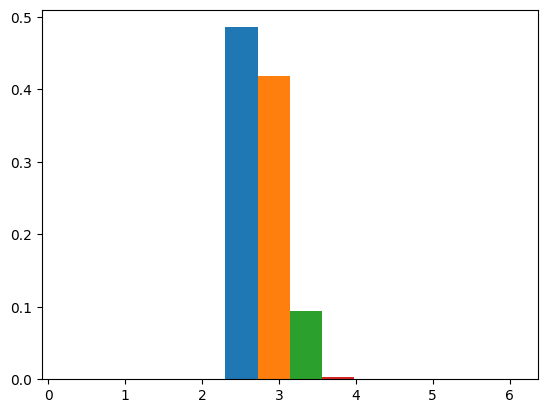

[527.41480194 323.08098443 537.50150587]


In [10]:
def compute_hog_descriptor(img_patch, n_cells=4, q=4):
    epsilon = 0.0001
    grad_x = opencv.Sobel(img_patch, opencv.CV_64F, 1, 0)
    grad_y = opencv.Sobel(img_patch, opencv.CV_64F, 0, 1)
    
    orientations = np.arctan2(grad_y, grad_x) + np.pi
    print(f'There are {np.sum(np.where(orientations > 2 * np.pi)[0])} orientations bigger than 2 * PI.')
    print(f'There are {np.sum(np.where(orientations < - 2 * np.pi)[0])} orientations tinier than -2 * PI.')
    magnitudes = np.sqrt(grad_x ** 2 + grad_y ** 2)
    hog_descriptor = []
    for rowIdx in range(img_patch.shape[0]//n_cells):
        for pixelIdx in range(img_patch.shape[1]//n_cells):
             # Compute sum of gradients magnitudes
             sum_gradient_magnitudes = np.sum(magnitudes[rowIdx*n_cells-n_cells:rowIdx*n_cells, pixelIdx*n_cells-n_cells:pixelIdx*n_cells])
             # Divide gradients magnitudes by the sum
             magnitudes[rowIdx*n_cells-n_cells:rowIdx*n_cells, pixelIdx*n_cells-n_cells:pixelIdx*n_cells] = magnitudes[rowIdx*n_cells-n_cells:rowIdx*n_cells, pixelIdx*n_cells-n_cells:pixelIdx*n_cells] / (sum_gradient_magnitudes + epsilon)
             intervals = np.linspace(0, 2*np.pi,q)
             this_orientations = orientations[rowIdx*n_cells-n_cells:rowIdx*n_cells, pixelIdx*n_cells-n_cells:pixelIdx*n_cells]
             this_magnitudes = magnitudes[rowIdx*n_cells-n_cells:rowIdx*n_cells, pixelIdx*n_cells-n_cells:pixelIdx*n_cells]
             # Concatenate all histograms of orientations with weighted magnitudes
             hog_descriptor.append(np.asarray(np.histogram(this_orientations, intervals, weights=this_magnitudes)[0]))
             # Further information for one specific example
             if rowIdx == 50 and pixelIdx == 34:
                 print(f'--- rowIdx == 50 and pixelIdx == 34 ---')
                 print("this_orientations")
                 print(this_orientations)
                 print("this_magnitudes")
                 print(this_magnitudes)
                 print("Weighted Histogram")
                 print(np.histogram(this_orientations, intervals, weights=this_magnitudes))
                 plt.hist(this_orientations, intervals, weights=this_magnitudes)
                 plt.show()
    # plt.imshow(magnitudes, cmap='grey')
    # plt.show()

    return np.asarray(hog_descriptor).flatten()

hog_descriptor = compute_hog_descriptor(image)


## Part 2. Build and train a BOVW classifier

First lets download the dataset and split it into a train and test set. We will not use the complete dataset but pick a smaller subset of classes

In [ ]:
import os
import sklearn
import urllib.request
import tarfile
import zipfile
import numpy as np

from sklearn.model_selection import train_test_split

# download dataset
filename = 'caltech-101.zip'
if not os.path.exists(filename):
    url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

    with tarfile.open('./caltech-101/101_ObjectCategories.tar.gz', "r:gz") as tar:
      tar.extractall()

# load with sklearn
ds_path = './101_ObjectCategories'
ds = sklearn.datasets.load_files(ds_path, allowed_extensions=['.jpg'], load_content=False)
fns = ds['filenames']
tgts = ds['target']

# take some classes
filtered_classes = ['faces', 'leopards', 'motorbikes', 'airplanes', 'ketch', 'schooner']

# get class ids by name
class_names = np.char.lower(ds['target_names'])
sorter = np.argsort(class_names)
cs = sorter[np.searchsorted(class_names, filtered_classes, sorter=sorter)]

idcs = list(map(lambda x: x in cs, tgts))
tgts = tgts[idcs]
fns = fns[idcs]

# filenames and labels for the train and test set images
fns_train, fns_test, y_train, y_test = train_test_split(fns, tgts, stratify=tgts,test_size=.20, random_state=42)

**4 Build the visual words dictionary:**
- Find all the keypoints in the training dataset
- Extract patches of some pre-defined size (e.g. 32 pixels of side) centred at the keypoints
- Compute the HOG descriptor of each image patch.
- Train a k-means clustering on the complete set of descriptors (for example, with k=8). Try different values of k.

**5 Train a Support Vector Machine classifier.**
- First, convert all the images of the dataset into their bag of visual words representation. Given an input image:
  - Find the corners, extract image patches, compute their HOG descriptors.
  - Apply the trained k-means on the features to predict their corresponding centroids.
  - Summarize the image as a histogram of the predicted centroids.
- Train a Support Vector Machine classifier using the BOVW representations of the images.
  - Use the $\chi^2$ kernel as kernel function. Make sure that the `gamma` parameter is correctly set as this influences classification performance.

**6 Report the results.**
- Report classification metrics on the test set and plot the confusion matrix.
- Please describe the reported metrices and the confusion matrix. What are your conclusions?

**Notes**
- Use `sklearn`'s k-means and Support Vector Machine for this exercise. Additionally, you can use any other functionality of `sklearn` if you require.
- Caltech101 images come in different size and shapes. Before finding keypoints, you could pre-process each image for example by resizing them to a smaller shape, as big images take longer to process.
- Throughout the assignment you had to make some design choices by picking _hyperparameters_ of your algorithm: the detector's NMS distance, HOG's `n_cells` and `q`, the keypoints' patch size, k-means' k, the kernel function's gamma, the pre-processing function, etc. These values have an effect on the classifier's performance, both in training/inference speed and in the classification metrics. **You should try out different values in order to maximize the algorithm's performance.**